# Pre Lab 09 : Curve Fitting

## Objectives

For the most part, this prelab is more about learning and less about doing. It is important to think about and understand what is presented here. The main objectives of this prelab are given below.
* Learn more about reading data from the web using `urllib.request` along with the `with` statement.
* Learn another way to avoid writing loops ourselves, even in cases when it looks like we would need to, by using the `np.vectorize()` function.
* Explore more carefully the meaning and use of the $\chi^2$, in particular the roles of the uncertainties. 

## Initialization

As always you should add initialization to the top of your notebook. We will need to generate random numbers so create and store a random number generator in `rng`.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sf
import scipy.optimize as opt

# Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

# For random numbers
rng = np.random.default_rng()

## Loading Data from Text Files

Plain text files are a common way of storing data. They have the advantage of being very flexible, readable by anyone (you can directly look at it), and platform independent. This flexibility comes at a cost. Since they need not follow a rigid structure they can be difficult and slow to parse.

For simple, well formed text files NumPy provides the `loadtxt` function. For more general text files we can instead use `genfromtxt`. We will explore both of these functions below.

### Reading Data from the Web

We have seen we can directly read data from the web using `urllib` without needing to download the file ourselves.
We will need to read a data file for the lab this week so will get some practice now.

There is more than one way to do this and if/when you search online you will find other code/approaches.
Rather than blindly copying some code, we will understand the implications of the approach we use.
Other approaches will do different things, in particular, *they will download the file and store it locally first*.
This is not necessarily bad, but it is different and it is not the approach given here.
It is nice that one can find recommendations online/from tools, that does not mean they are the approach you want to use.
Just because the provided code "works" it does not mean that it is good.

In our approach we **will not store the file on our computer**.
We will directly read the data from the remote source.

Given a url in a variable called `url` we can open the file using
```
import urllib.request
fp = urllib.request.urlopen(url)
```
Though this works, it is not the best way to do things.

### The `with` Statement

The simple way we described things above is actually bad practice. What we really should do when we open and read a file is
1. Open the file.
2. Check/catch any errors.
3. Read the data.
4. Close the file (that is, clean up after ourselves), regardless of whether parsing the file worked or gave an error.

In general we do not do this, we just open the file, read it, and forget about it, hoping everything just worked. Fortunately, there is an idiomatic way to do this more correctly in Python by using the `with` statement. For our purpose the `with` statement just provides a local definition of some object, allows us to use it in a block of code, then cleans up this object after the block of code is executed.

We will use this below. In our examples we will open the remote file using `urllib`, call this opened file `fp`, and then read it. Once the code in the `with` block is done executing the object `fp` will no longer exist and cannot be used again. It will be properly closed for us. 

### `loadtxt()`

There are a number of data sets available for extracting information about the expansion rate of the Universe from type Ia supernova observations. More recent sources provide detailed data, for example from [Pan-STARRS](https://archive.stsci.edu/prepds/ps1cosmo/) or from [Pantheon+SHOES](https://github.com/PantheonPlusSH0ES/DataRelease). Such sources give the full information about each supernova to allow us to model their light curves, apply color corrections to calibrate them, *etc.* While that would be essential if we were performing a careful scientific analysis of the data, that is not what we want to do here. We will use a simpler (and older) data set that has done some of the processing for us already. We will only focus on the cosmology, not on the astrophysics.

Thus, the data we will use for the lab this week comes from the Supernova Cosmology Project (the Union 2.1 set). It is stored in a text file that you may access from its original site at
http://supernova.lbl.gov/union/figures/SCPUnion2.1_mu_vs_z.txt .
More details about the data is given in the lab. Here we are just interested in reading it.

Note that this is an actual data file used in research projects. See the [Supernova Cosmology Project page](http://supernova.lbl.gov/union/) for more information. As noted above, we can directly read this data file from the web without having to download it! To read a text file, `np.loadtxt` is the simplest choice. It is meant to be used to read simple text files where the same number of data values are given in each line of the file. This will mostly work in our case.

The code below is the general method for doing this. You should see that it does not quite work, an exception is raised about a conversion error.

In [19]:
url = "http://supernova.lbl.gov/union/figures/SCPUnion2.1_mu_vs_z.txt"
import urllib.request
with urllib.request.urlopen(url) as fp:
    X = np.loadtxt(fp)

ValueError: could not convert string '1993ah' to float64 at row 0, column 1.

The "problem" is that the first column contains strings (the names of the supernova). Unfortunately `np.loadtxt()` assumes that all columns contain numbers. Fortunately we can get around this by only reading in the columns we need. In this case we will only use columns two, three, and four (again, see the lab for details).

Modify the code above to allow us to read the datafile using `np.loadtxt()`, but only read in columns two, three, and four. Print to result to show that you have actually read in the correct data. (*Hint:* See the documentation for `np.loadtxt()` and pay particular attention to the `usecols` keyword. The `unpack` keyword will also be convenient to use in the lab, though it need not be used here.)

In [20]:
url = "http://supernova.lbl.gov/union/figures/SCPUnion2.1_mu_vs_z.txt"
import urllib.request
with urllib.request.urlopen(url) as fp:
    X = np.loadtxt(fp, usecols=(1,2,3))
print(X)

[[2.84880000e-02 3.53465834e+01 2.23905933e-01]
 [5.00430000e-02 3.66823679e+01 1.66828851e-01]
 [5.29260000e-02 3.68176913e+01 1.55755915e-01]
 ...
 [8.21000000e-01 4.36409388e+01 1.94013592e-01]
 [1.21500000e+00 4.52465209e+01 5.60317445e-01]
 [6.23000000e-01 4.25145240e+01 2.41428135e-01]]


### `genfromtxt()`

The more general, and thus more complicated, function for reading a text file is `genfromtxt`. This can handle text files with different numbers of values on each line. It has many, many options that can be used to read data from files even with crazy formatting choices. **We do not need to use `genfromtxt()` for our data file.** Even so, it is worth seeing what it does. Run the following cell.

In [21]:
with urllib.request.urlopen(url) as fp:
    data = np.genfromtxt(fp)
print(data)

[[           nan 2.84880000e-02 3.53465834e+01 2.23905933e-01
  1.28418942e-01]
 [           nan 5.00430000e-02 3.66823679e+01 1.66828851e-01
  1.28418942e-01]
 [           nan 5.29260000e-02 3.68176913e+01 1.55755915e-01
  1.28418942e-01]
 ...
 [           nan 8.21000000e-01 4.36409388e+01 1.94013592e-01
  5.51671793e-01]
 [           nan 1.21500000e+00 4.52465209e+01 5.60317445e-01
  1.47652666e-04]
 [           nan 6.23000000e-01 4.25145240e+01 2.41428135e-01
  5.51671793e-01]]


Notice that it read in the full file, filling in `nan` for the strings. Not necessarily ideal, but at least it did read in all the numeric information.

## Function vectorization

As we have seen, operating on an array of values is easier and more efficient than writing our own loop to evaluate the values one at a time. When performing fits to data we must have a function that accepts and evaluates an array of input values. Unfortunately there are some functions that do not work in this way. Consider the example of an integral; suppose we wish to evaluate 
$$ f(x) = \int_0^x y^2 \,\mathrm{d}y. $$
The simple way to implement this is given below. It suffers from the fact that we cannot pass an array, `x`, to `scipy.integrate.quad()`. (Actually, we know that `scipy.integrate.quad_vec()` exists and it can be used in many cases. Even so, we are going to ignore it for this discussion. In this case, `x` is in the limit of integration and `quad_vec()` does not easily support this. We would need to modify the calculation to "move" `x` out of the limit of integration. In addition, from limited experience, `quad_vec()` is not a trivial drop-in replacement for a vectorized version of `quad()` so I will not consider its use in the calculation we are to perform. Instead, we are going to introduce a different way of vectorizing functions. The prelab and lab will be written with this in mind. You can explore the use of `quad_vec()`, if desired.) In the past we would have written a loop to go through all the values of `x` and compute the integrals one at a time. An alternative approach is to let NumPy vectorize the function for us using `np.vectorize()`. **We will encounter a use for `vectorize` in the lab this week.** Make sure you understand the following example.

Study and Run the following example:

In [22]:
import scipy.integrate as integ
def y(x):
    return x**2

def f(x):
    return integ.quad(y, 0, x)[0]
# With this setup we can verify it works by doing, for example
f(1)

0.33333333333333337

So it works for a single value, this is not surprising. On the other hand, it does not work if we pass in an array. Instead we get a hard to understand error (truth value?). You should look at the error message; it is actually a fairly common message that appears whenever we try to use an array when only a single number should appear.

In [23]:
x = np.linspace(1, 2, 10)
# This should produce an error.
f(x)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

On the other hand, if we vectorize the code it magically works! (*Note:* Again, even though `quad_vec()` exists, there will always be cases where a function will not already be vectorized for us and `np.vectorize()` will be a convenient way to work around this.)

In [24]:
# Instead we can define a new function F(x) using vectorize():
F = np.vectorize(f)
# Now ...
F(x)

array([0.33333333, 0.45724737, 0.60859625, 0.79012346, 1.00457247,
       1.25468679, 1.54320988, 1.87288523, 2.24645633, 2.66666667])

It should be noted that `np.vectorize()` is not actually working magic and **does not make your code faster**, it is merely a convenience function that allows you to avoid explicitly writing a loop. Essentially what it is does is "write the loop for you". It loops over your input arrays and executes the function once for each value in the arrays, collects these values, and returns them to you in a new array. The case encountered here is one example where this is useful.

## Understanding the $\chi^2$

We have introduced the $\chi^2$ and will use it to fit for parameters of a model given some data, but what is it really? We know that given some data represented by the values $y_i$ and uncertainties $\sigma_i$ when evaluated at some points $x_i$ we can fit for the parameters, $\vec p$, of a model $f(x, \vec p)$. Even if $f(x, \vec p)$ is a linear function of the parameters, $\vec p$, when there are more data points, $\vec y$, than there are parameters, $\vec p$, there will **not be a unique solution** for $\vec p$. Instead we look for a set of parameters such that the curve described by the model is "close" to the data. Many choices could be made to define what "close" means. The one we make when performing least squares fitting is to minimize the $\chi^2$ defined by
$$ \chi^2 = \sum_{i=1}^{n} \left( \frac{ y_i - f(x_i, \vec p) }{\sigma_i} \right)^2. $$
This choice makes some sense, it looks similar to the distance between points in Euclidean space (otherwise known as the Pythagorean theorem).

The $\chi^2$ is useful even without performing a fit. Since it gives a measure of the "distance" between the data and a model, it can be used to quantify how "good a fit" the model is to the data. Unfortunately this *is* the way it is phrased. We talk about "goodness of fit" even when the $\chi^2$ is not minimized in order to find the best fit parameters. In other words, the $\chi^2$ can be used to perform model comparisons. When we speak of the "goodness of fit" we mean the probability that the $\chi^2$ would exceed the value calculated by chance for the number of degrees. In statistics this is referred to as a one-sided $p$-value. We will continue to call it the goodness of fit, but it is perhaps better to think of it as a $p$-value.

To get some practice and gain more familiarity with the $\chi^2$ we will generate some fake data and analyze it. You should think about each of the comparisons performed below to develop some intuition of what to look for in plots of data. Essentially we want to gain some experience in performing "chi by eye", this means to get a rough idea of how well a model agrees with the data just by looking at plots. This is a common thing to do when seeing data presented in talks or a paper!

### Generating Random Data

To begin, we generate some random data for the simple curve
$$ y(x, A, \phi) = A\sin(x+\phi) $$
with $A=4$ and $\phi=0.4$. We first generate random $x$ values in the range $0\le x<3\pi$. With these we calculate the true values from the curve and then generate random fluctuations to represent observational uncertainties. Here we use Gaussian noise with a constant uncertainty for all observations $\sigma_y$. (This is of course not necessary, it just makes the calculations a little easier.)

**Run the following cell.** We want to use the same data for all our analyses below. If you rerun this cell you will get new random data and must rerun all your analysis cells so that the results are consistent. (You are encouraged to generate and analyze a number of different sets of random data to see how the results can vary.)

In [25]:
# Generate random data. Rerun all subsequent analysis cells after this.
A = 4.0
phi = 0.4
sigma_y = 2
x = rng.random(size=30) * 3*np.pi
def ymodel(x, A, phi):
    return A * np.sin(x + phi)
ytrue = ymodel(x, A, phi)
y = ytrue + sigma_y * rng.normal(size=len(x))

### True Model Comparison

For our random data we know the values of the parameters $A$ and $\phi$ from the true model. We will use this to see what a "good" model should look like.

The first thing we should do is plot the data and a curve representing the true model. Make a quick plot using `errorbar` to plot the data and include a curve for the model as usual.

Text(0.5, 1.0, 'Data and Model for a Sine Wave')

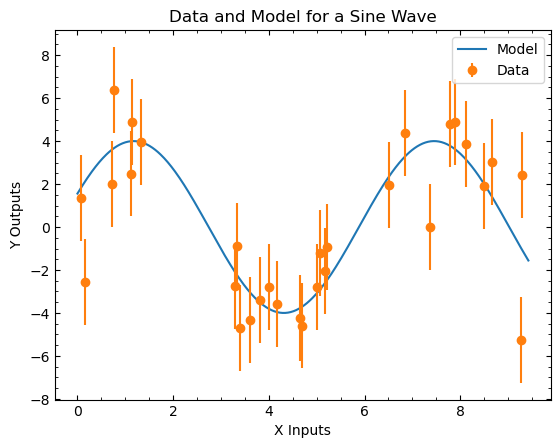

In [26]:
xtrue=np.linspace(0,3*np.pi,500)
plt.plot(xtrue, ymodel(xtrue,A,phi), label='Model')
plt.errorbar(x,y, yerr=sigma_y, fmt='o', label='Data')
plt.legend()
plt.xlabel('X Inputs')
plt.ylabel('Y Outputs')
plt.title('Data and Model for a Sine Wave')

Calculate the $\chi^2$ using the true values for the parameters $A$ and $\phi$ in the model. Print the $\chi^2$, the number of degrees of freedom, and the goodness of fit. (*Hint:* We are **not** performing a fit so how many parameters are we allowing to vary and what does this mean for the number of degrees of freedom?)

In [27]:
chi2 = np.sum(((y - ymodel(x, A, phi)) / sigma_y)**2)
dof = len(y) 
gof = sf.gammaincc(0.5*dof, 0.5*chi2)
print(f'chi^2 = {chi2}\nDegrees of Freedom: {dof}\nGoodness of Fit = {gof}')

chi^2 = 26.44385687445881
Degrees of Freedom: 30
Goodness of Fit = 0.6522965033179153


### Uncertainties

The uncertainty, $\sigma_y$, plays a very important role in the fit. It sets the scale for how accurately we know each data point and thus how much weight we should give to each data point. In every case we have discussed, will encounter, and probably have encountered, we mean that the uncertainty "has the same units" as the data and is already "normalized" to the data. It seems that there are other choices. For example, the [weighted least squares](https://en.wikipedia.org/wiki/Weighted_least_squares) is one generalization. Unfortunately, it seems this is the choice made as the default in `scipy.optimize.curve_fit`. I do not understand why this choice would be made, but it means that **we must always use** `absolute_sigma=True`. If we do not, the uncertainties in our fit parameters will not be reported correctly!

Even before we perform a fit, we can explore the role of uncertainties. We may think it is best to *overestimate* the uncertainty "just to be safe". Recalculate the $\chi^2$ now using twice the uncertainty, meaning replace $\sigma_y$ with $2 \sigma_y$ in your calculation. Print the $\chi^2$, the number of degrees of freedom, and the goodness of fit for this case. Also produce another quick plot of the data and the true model but now with the doubled uncertainty for the error bars on the data.

chi^2 = 6.610964218614702
Degrees of Freedom: 30
Goodness of Fit = 0.9999978355538208


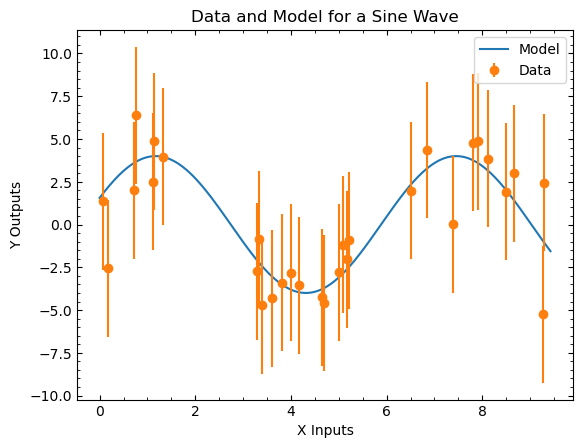

In [28]:
plt.plot(xtrue, ymodel(xtrue,A,phi),  label='Model')
plt.errorbar(x,y, yerr=2*sigma_y, fmt='o', label='Data')
plt.legend()
plt.xlabel('X Inputs')
plt.ylabel('Y Outputs')
plt.title('Data and Model for a Sine Wave')

chi2 = np.sum(((y - ymodel(x, A, phi)) / (2*sigma_y))**2)
dof = len(y) 
gof = sf.gammaincc(0.5*dof, 0.5*chi2)
print(f'chi^2 = {chi2}\nDegrees of Freedom: {dof}\nGoodness of Fit = {gof}')

Based on the $\chi^2$, goodness of fit, **and from the plot itself** explain why this result does not look correct. The goodness of fit should be very, very close to one, why is this a problem?

Visually examining the plot, we can see that somewhere between every and almost every data point is within $1-\sigma$ of the model. We expect 68% of the data to be that close, so this is cause for concern. We also see that the $\chi^2$ is much smaller than the degrees of freedom, which is yet another cause for concern. Ideally, our $\chi^2$ is roughly equal to our degrees of freedom, $\nu$, so that each point we sum over contibutes roughly 1 to the total $\chi^2$. Here, each point is contributing significantly less, which is an indication something has gone wrong. We can tell visually that the data does not fit the model exceptionally well, so we should also be dubious of such a high goodness of fit. 

Alternatively, we might want to "show off" how good we are at performing experiments and thus *underestimate* the uncertainties. We also should never do this! Repeat the previous calculation now with $\sigma_y$ instead replaced by $\sigma_y/2$. Print the $\chi^2$, the number of degrees of freedom, and the goodness of fit for this case. Also produce another quick plot of the data and the true model but now with the halved uncertainty for the error bars on the data.

chi^2 = 105.77542749783524
Degrees of Freedom: 30
Goodness of Fit = 2.2259024693640242e-10


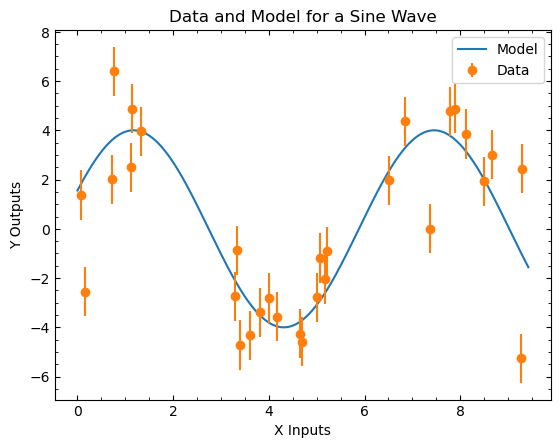

In [29]:
plt.plot(xtrue, ymodel(xtrue,A,phi),  label='Model')
plt.errorbar(x,y, yerr=.5*sigma_y, fmt='o', label='Data')
plt.legend()
plt.xlabel('X Inputs')
plt.ylabel('Y Outputs')
plt.title('Data and Model for a Sine Wave')

chi2 = np.sum(((y - ymodel(x, A, phi)) / (.5*sigma_y))**2)
dof = len(y) 
gof = sf.gammaincc(0.5*dof, 0.5*chi2)
print(f'chi^2 = {chi2}\nDegrees of Freedom: {dof}\nGoodness of Fit = {gof}')

Based on the $\chi^2$, goodness of fit, **and from the plot itself** explain why this model does not agree well with the data.

Visually examining the plot, we can see that very few of the data points are within $1-\sigma$ of the model. We expect 68% of the data to be that close, so this is cause for concern. We also see that the $\chi^2$ is about three times as large as the degrees of freedom, which is yet another cause for concern. Ideally, our $\chi^2$ is roughly equal to our degrees of freedom, $\nu$, so that each point we sum over contibutes roughly 1 to the total $\chi^2$. Here, each point is contributing significantly more, which is an indication something has gone wrong. The goodness of fit confirms this: it is very close to 0.  

### Best Fit

Finally we *can* minimize the $\chi^2$ to find the best fit values for the parameters $A$ and $\phi$. It may come as a surprise to note that the best fit values are **not the true values**, even though we have generated fake data using particular values for the parameters, know the true errors, *etc*. You should find the $\chi^2$ is smaller **but the goodness of fit may not be better** when the parameters take on values different than the true ones. Further, the values of the parameters should be "close" to the true values with "close" here being defined by the uncertainties in the best fit parameter values.

Perform a fit to the model using `scipy.optmize.curve_fit`. Do not forget to use `absolute_sigma=True`. Print the best fit values for the parameters $A$ and $\phi$ along with their uncertainties. Also print the $\chi^2$, the number of degrees of freedom, and the goodness of fit for the parameters found from this fit. (*Hint:* Since the parameters are now being fit for, what should the number of degrees of freedom be?)

In [30]:
(p, C) = opt.curve_fit(ymodel, x, y, sigma=sigma_y, absolute_sigma=True)

#put this in after the fact oops
sigp = np.sqrt(np.diag(C))
chisq = np.sum(((y - ymodel(x, *p)) / sigma_y)**2)
dof = len(y) - len(p)
Q = sf.gammaincc(0.5*dof, 0.5*chisq)

print(f"""Best fit:
A = {p[0]} +/- {sigp[0]}
phi = {p[1]} +/- {sigp[1]}
{chisq = }
{dof = }
goodness of fit = {Q}""")

Best fit:
A = 3.821816563313941 +/- 0.47707024870757103
phi = 0.3672930677875634 +/- 0.15004183513030936
chisq = 26.238193785282224
dof = 28
goodness of fit = 0.5599534408734352


Produce a nice figure showing the data with its errors bars. Include in the figure a curve representing the true model and one representing the best fit model. (*Note:* It may not be obvious that the best fit model has a small $\chi^2$, though it is worth staring at your figure to see that it seems plausible. Depending on your random realization the two curves may or may not be very different.)

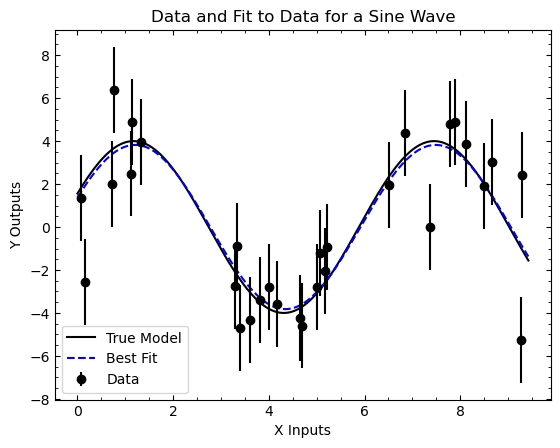

In [31]:
plt.plot(xtrue, ymodel(xtrue, A, phi), 'k-', label='True Model')
plt.plot(xtrue, ymodel(xtrue, *p), 'b--', label='Best Fit')
plt.errorbar(x, y, yerr=sigma_y, fmt='ko', label='Data')
plt.xlabel('X Inputs')
plt.ylabel('Y Outputs')
plt.title('Data and Fit to Data for a Sine Wave')
plt.legend(loc='lower left')

### What did we just learn?

The calculations performed above are nice, but what do we learn from them? The answer is somewhat subtle; such is the nature of statistics. Since we are using random data, some of the small details of the calculations can change. It is worthwhile to rerun the calculations for a few different data sets to see which results change and which do not. (If you do this you should make sure you leave your notebook in a state where all the calculations have been run for the same set of random data.) We should find that the $\chi^2$ and goodness of fit for a model using the true parameters varies, perhaps even significantly. On the other hand, doubling the error bars always leads to a goodness of fit extremely close to one and halving the error bars always leads to a very small goodness of fit. Finally, the best fit parameters will not be the true values but will always be close (usually within 2 or 3 times the uncertainty in the parameters), the $\chi^2$ will be smaller than that from the model with the known parameters, but the goodness of fit will sometimes be smaller and sometimes be larger.

This last point may seem strange. How can it be that we have the best fit parameters and yet the goodness of fit be worse? The important point is that **when we perform a statistical calculation we are answering a specific question**. We must clearly understand the question we are asking before we can interpret the results. Further, if we ask a different question we will get a different answer and it is often difficult to know how to compare the results from two different statistical calculations.

In the calculations performed here we have asked two different questions. In the first case we had a fixed model with **no free parameters**. Here we were asking how close is the data to a particular model with particular values for the parameters. In the second case we had a model with two parameters which could be optimized to find the values that best reproduce the data (best in the least squares sense). Here we were asking for the best fit values of the parameters in our model given the data. The "fitting" performed used some of the information in the data points to tune the values of the parameters, thus all of the data points were no longer independent pieces of information. Since we were asking different questions it is not surprising that trying to compare the values for the goodness of fit between the two cases can be confusing.

Turning this around, comparing different cases such as we have here can be used to address the question of whether the data justifies (or needs) a more complicated model. Do we need to add more parameters to the model and fit for their best values? If adding more parameters does not increase the goodness of fit then we are not justified in adding them.

## Turning in the PreLab

All prelabs will be handled as was done for PreLab01. See that file for details. It will be assumed from now on that you have read and understood the procedure and what it means when you submit a prelab.